In [114]:
%pip install accelerate

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [47]:
import os
import torch
import torchvision
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import OrderedDict
import datetime

In [106]:
# import accelerate
import models
import importlib
import helper
import config

In [4]:
import time

In [125]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# workdir = '/Users/erichansen/Desktop/Classes/9.520/project/'
workdir = './'

# Config

In [7]:
global_config = config.get_global_configuration()
device = global_config['device']

cuda:0


In [181]:
importlib.reload(models)
importlib.reload(helper)
importlib.reload(config)

<module 'config' from '/home/ec2-user/SageMaker/layerwise-nn-optimization/config.py'>

In [9]:
m1 = models.LayerwiseConfigurableCNN()
m2 = models.LayerwiseConfigurableMLP()

# Training

In [166]:
def get_top1_pos(outputs, targets):
    pred = np.argmax(outputs, axis=1)
    assert(len(pred) == len(targets))
    
    return np.sum(np.where(pred == targets, 1, 0))

def get_top5_pos(outputs, targets):
    sm = 0
    for i in range(len(targets)):
        top_5 = np.argpartition(outputs[i], -5)[-5:]
        sm += 1 if targets[i] in set(top_5) else 0 
    
    return sm

def evaluate_model(model, data_loader, loss_function, device='cpu'):    
    output_data = []
    targets_data = []
    current_loss = 0
    
    for i, data in enumerate(data_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        # Perform forward pass
        outputs = model(inputs)
        
        if str(device) != 'cpu':
            outputs = outputs.cpu()
            targets = targets.cpu()
            
        output_data.extend(outputs.detach().numpy())
        targets_data.extend(targets.detach().numpy())

        loss = loss_function(outputs, targets)
        current_loss += loss.item()
        
    N = len(targets_data)
    top1_acc = get_top1_pos(output_data, targets_data) / N
    top5_acc = get_top5_pos(output_data, targets_data) / N
    
    return current_loss / float(N), top1_acc, top5_acc    


def train_model(model, device='cpu', epochs=None, invariant=False, output=False):
    """ Train a model. """
    model_config = config.get_model_configuration()
    print(device)
    
    loss_function = model_config.get("loss_function")()
    optimizer = model_config.get("optimizer")(model.parameters(), 
                                              lr=model_config.get('learning_rate'),
                                              weight_decay=model_config.get('weight_decay'))
    trainloader = helper.get_dataset(train=True, invariant=invariant)
    testloader = helper.get_dataset(train=False, invariant=invariant)

#     Accelerate model
#     accelerator = accelerate.Accelerator()  
#     model, optimizer, trainloader = accelerator.prepare(model, optimizer, trainloader)

    # Iterate over the number of epochs
    entries = []
    
    if epochs is None:
        epochs = model_config.get("num_epochs")
    
    for epoch in range(epochs):
        # Print epoch
        if output:
            print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        
        output_data = []
        targets_data = []
 
        # Iterate over the DataLoader for training data
        st_time = time.time()
        for i, data in enumerate(trainloader, 0):
#             print(i)

            # Get inputs
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, targets)

            current_loss += loss.item()
            
            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

        end_time = time.time()
        
        if (epoch % 1 == 0) or (epoch == (epochs - 1)):
            test_loss, test_top1_acc, test_top5_acc = evaluate_model(model, testloader ,loss_function, device=device)
            train_loss, train_top1_acc, train_top5_acc = evaluate_model(model, trainloader ,loss_function, device=device)
            if output:
                print(f'Train Acc: {train_top1_acc}')
                print(f'Test Acc: {test_top1_acc}')
        else:
            test_loss, test_top1_acc, test_top5_acc = pd.NA, pd.NA, pd.NA
            train_loss, train_top1_acc, train_top5_acc = pd.NA, pd.NA, pd.NA
        
        elapsed_time = round(end_time - st_time, 1)
        train_entry = {'type': 'train', 'epoch': epoch, 'top1': train_top1_acc, 'top5': train_top5_acc,
                       'loss': train_loss, 'time': elapsed_time}
        
        if output:
            print(f'Loss: {current_loss}')
            print(f'Time: {elapsed_time}')

        test_entry = {'type': 'test', 'epoch': epoch, 'top1': test_top1_acc, 'top5': test_top5_acc,
                      'loss': test_loss, 'time': pd.NA}
        
        entries.extend([train_entry, test_entry])
        
#         break


    # Return trained model
    return model, pd.DataFrame(entries), current_loss

In [167]:
cnn = models.LayerwiseConfigurableCNN()
# mlp = mlp.to(device)
# cnn, cnn_df, loss = train_model(cnn)

In [168]:
mlp = models.LayerwiseConfigurableMLP()
# mlp = mlp.to(device)
# mlp, mlp_df, loss = train_model(mlp)

In [182]:
def add_config_columns(results_df):
    model_config = config.get_model_configuration()
    results_df['optimizer'] = str(model_config['optimizer'])
    results_df['hidden_layer_dim'] = model_config['hidden_layer_dim']
    results_df['batch_size'] = model_config['batch_size']
    results_df['batch_norm'] = model_config['batch_norm']
    results_df['weight_decay'] = model_config['weight_decay']
    results_df['learning_rate'] = model_config['learning_rate']
    results_df['invariant'] = global_config['invariant']
    
    return results_df

In [187]:
def greedy_layerwise_training(model, rnd=0, output=False):
    """ Perform greedy layer-wise training. """    
    print("NEW!")
    global_config = config.get_global_configuration()
    device = global_config.get('device')
    print(device)
    model = model.to(device)
    torch.manual_seed(42)

    # Loss comparison
    loss_comparable = float('inf')

    # Iterate over the number of layers to add
    training_losses = []
    top5_accs = []
    top1_accs = []
    
    dfs = []
    for num_layers in range(global_config.get("num_layers_to_add")):
        if len(model.hidden_blocks) < num_layers:
            # Add layer to model
            model.add_hidden_block(device)
            model = model.to(device)
        
        active_layer = model.input_block if num_layers == 0 else model.hidden_blocks[num_layers - 1]
        model.activate_layers([active_layer])
        if num_layers > 0:
            model.freeze_layers([model.input_block] + [model.hidden_blocks[i] for i in range(num_layers-1)])
        
        # Print which model is trained
        if output:
            print("="*100)
            if num_layers > 0:
                print(f">>> TRAINING THE MODEL WITH {num_layers} ADDITIONAL LAYERS:")
            else:
                print(f">>> TRAINING THE BASE MODEL:")

        # Train the model
        model, df, end_loss = train_model(model, device=device, invariant=global_config['invariant'])
        df['layer'] = num_layers
        df['layer_params'] = model.num_trainable_weights()
        dfs.append(df)

        # Compare loss
        if output:
            if num_layers > 0 and end_loss < loss_comparable:
                print("="*50)
                print(f">>> RESULTS: Adding this layer has improved the model loss from {loss_comparable} to {end_loss}")
            elif num_layers > 0:
                print("="*50)
                print(f">>> RESULTS: Adding this layer did not improve the model loss from {loss_comparable} to {end_loss}")
        loss_comparable = end_loss
        # Add layer to model
#         break

    # Process is complete
    print("Training process has finished.")
    
    results_df = pd.concat(dfs)
    results_df = add_config_columns(results_df)
    results_df['model'] = model.get_name()
    results_df['round'] = rnd
    results_df['train_strategy'] = 'layerwise'
    results_df['model_strategy'] = results_df['model'] + '_' + results_df['train_strategy']

    
    results_df.to_csv(workdir + f'results/{helper.get_datetime_str(datetime.datetime.now())}.csv')
    print('finished')
    
    return model, results_df

In [217]:
def full_backprop_training(model, output=False, rnd=0):
    """ Perform greedy layer-wise training. """    
    global_config = config.get_global_configuration()
    device = global_config.get('device')
    model = model.to(device)
    torch.manual_seed(42)

    # Loss comparison
    loss_comparable = float('inf')

    # Iterate over the number of layers to add
    training_losses = []
    top5_accs = []
    top1_accs = []
    
    dfs = []
    for i in range(global_config.get("num_layers_to_add")):        
        model, df, end_loss = train_model(model, device=device, invariant=global_config['invariant'])
        if output:
            print(i)
            print(end_loss)

        df['layer'] = len(model.hidden_blocks)
        df['layer_params'] = model.num_trainable_weights()
        dfs.append(df)
        
        if rnd == 0:
            model.add_hidden_block(device)
            model = model.to(device)
    
    results_df = pd.concat(dfs)
    results_df = add_config_columns(results_df)
    results_df['model'] = model.get_name()
    results_df['round'] = rnd
    results_df['train_strategy'] = 'backprop'
    results_df['model_strategy'] = results_df['model'] + '_' + results_df['train_strategy']
        
    results_df.to_csv(workdir + f'results/{helper.get_datetime_str(datetime.datetime.now())}.csv')
    print('finished')
    
    return model, results_df

In [156]:
import seaborn as sns

In [ ]:
def last_epoch_df(df):
#     def last_epoch_grp(grp):
#         return grp[grp['epoch'] == grp['epoch'].max()]
    return df.groupby(by=['model', 'rnd', 'train_strategy'])

In [ ]:
df = pd.read_csv()

In [215]:
all_df

,Unnamed: 0,type,epoch,top1,top5,loss,time,layer,layer_params,optimizer,hidden_layer_dim,batch_size,batch_norm,weight_decay,learning_rate,invariant,model,round,train_strategy,model_strategy
0,0,train,0,0.52132,0.93642,0.005413,4.9,4,15286,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,CNN,1,backprop,CNN_backprop
1,1,test,0,0.50050,0.93190,0.005585,NaN,4,15286,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,CNN,1,backprop,CNN_backprop
2,2,train,1,0.52986,0.93872,0.005312,4.9,4,15286,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,CNN,1,backprop,CNN_backprop
3,3,test,1,0.51040,0.93120,0.005502,NaN,4,15286,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,CNN,1,backprop,CNN_backprop
4,4,train,2,0.53364,0.93596,0.005319,5.0,4,15286,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,CNN,1,backprop,CNN_backprop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1,test,0,0.48250,0.91200,0.005897,NaN,7,1249802,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,MLP,1,backprop,MLP_backprop
20,2,train,1,0.49714,0.92404,0.005660,4.9,7,1249802,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,MLP,1,backprop,MLP_backprop
21,3,test,1,0.47240,0.90960,0.005997,NaN,7,1249802,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,MLP,1,backprop,MLP_backprop
22,4,train,2,0.50514,0.92480,0.005602,4.7,7,1249802,<class 'torch.optim.adamw.AdamW'>,1024,250,False,0.01,0.001,False,MLP,1,backprop,MLP_backprop


In [214]:
all_df = helper.get_results_files(workdir + 'results/', '2022-12-09-04-17', '2022-12-09-05-10')

# By Epoch Graphs

In [216]:
sns.relplot(
    data=all_df[(all_df['model_strategy'] == 'CNN_layerwise') & (all_df['layer'] == all_df['layer'].max())],
    x='epoch',
    y='loss',
    hue='type',
    col='round',
    col_wrap=3
)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1080x0 with 0 Axes>

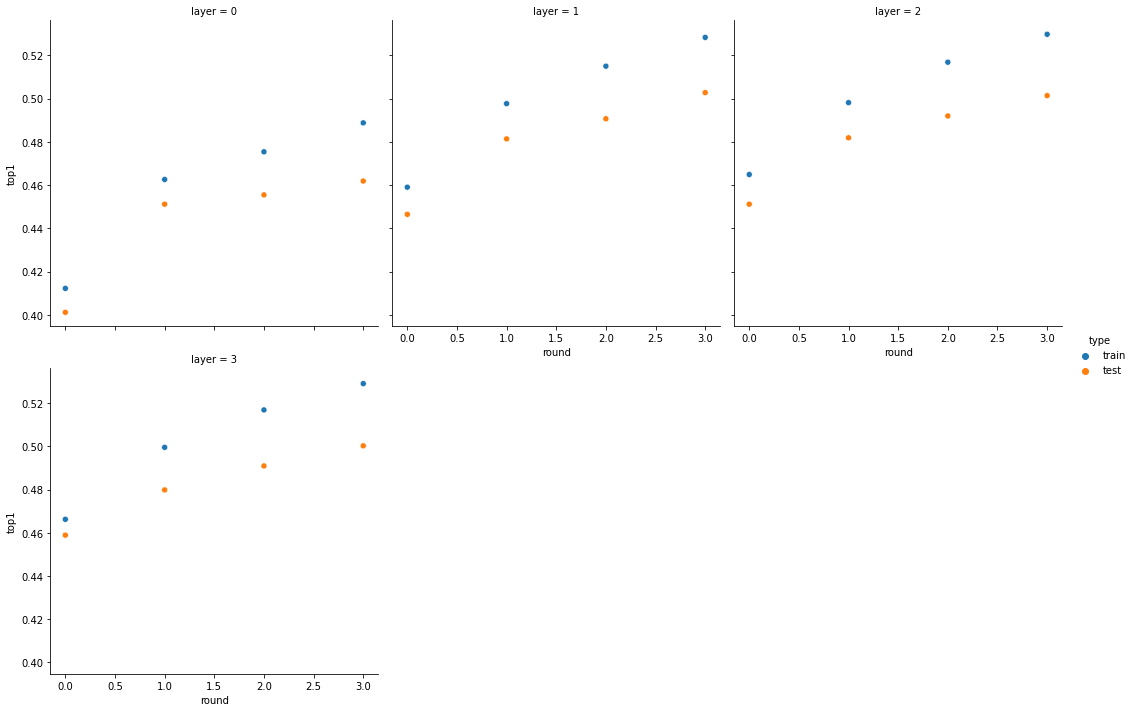

In [197]:
sns.relplot(
    data=all_df[(all_df['model_strategy'] == 'MLP_layerwise') & (all_df['epoch'] == all_df['epoch'].max())],
    x='round',
    y='top1',
    hue='type',
    col='layer',
    col_wrap=3
)

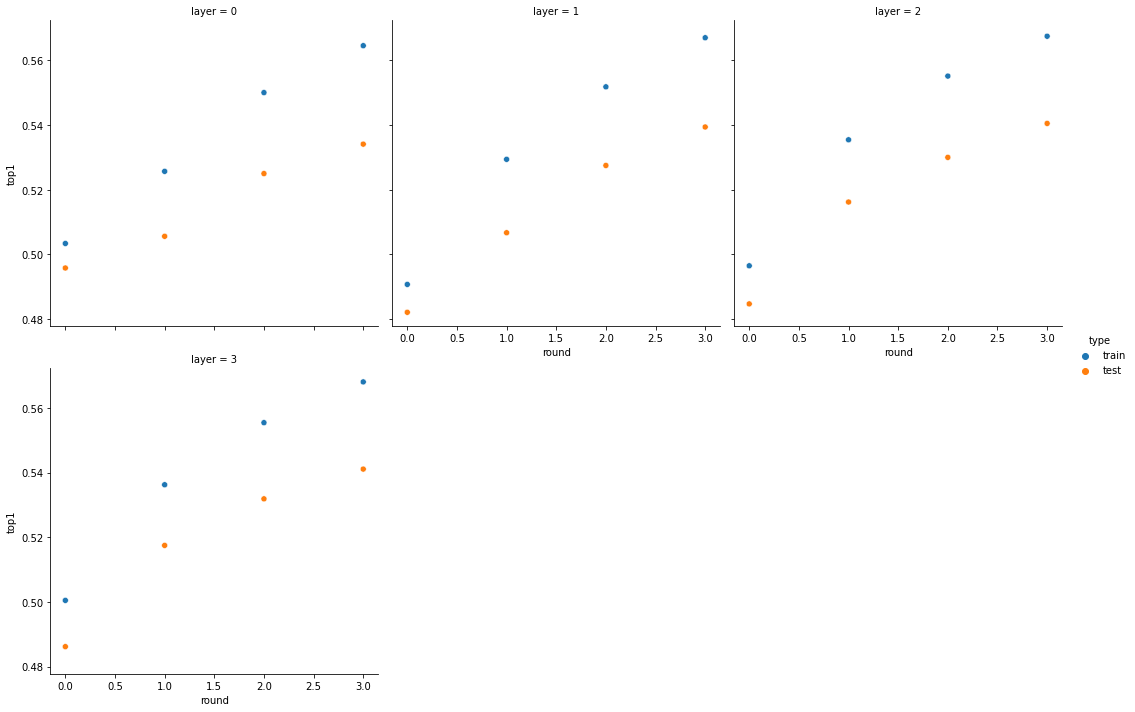

In [196]:
sns.relplot(
    data=all_df[(all_df['model_strategy'] == 'CNN_layerwise') & (all_df['epoch'] == all_df['epoch'].max())],
    x='round',
    y='top1',
    hue='type',
    col='layer',
    col_wrap=3
)

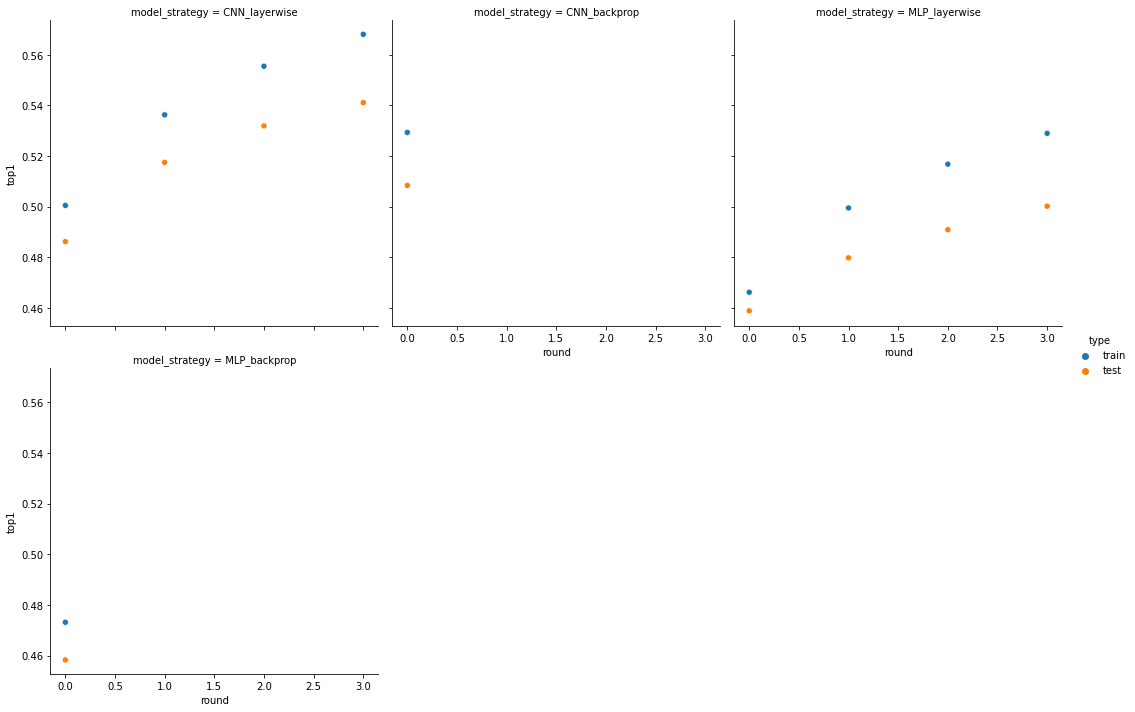

In [203]:
sns.relplot(
    data=all_df[(all_df['epoch'] == all_df['epoch'].max()) & (all_df['layer'] == all_df['layer'].max())],
    x='round',
    y='top1',
    hue='type',
    col='model_strategy',
    col_wrap=3
)

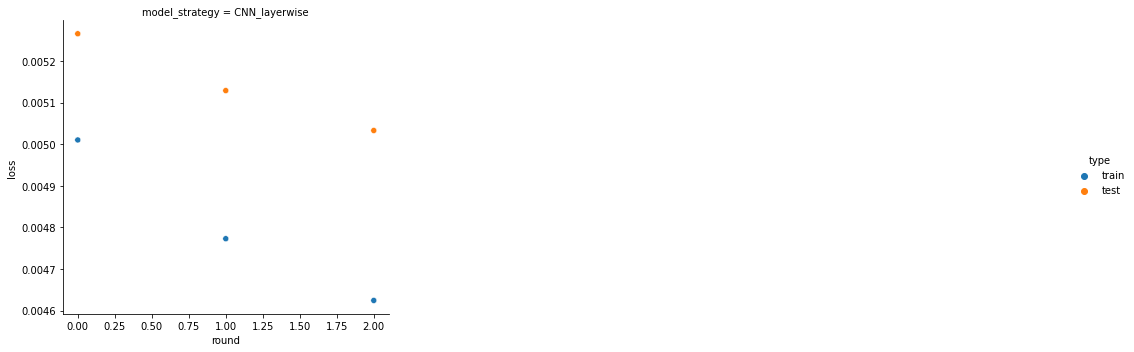

In [178]:
sns.relplot(
    data=all_df[(all_df['epoch'] == all_df['epoch'].max()) & (all_df['layer'] == all_df['layer'].max())],
    x='round',
    y='loss',
    hue='type',
    col='model_strategy',
    col_wrap=3
)

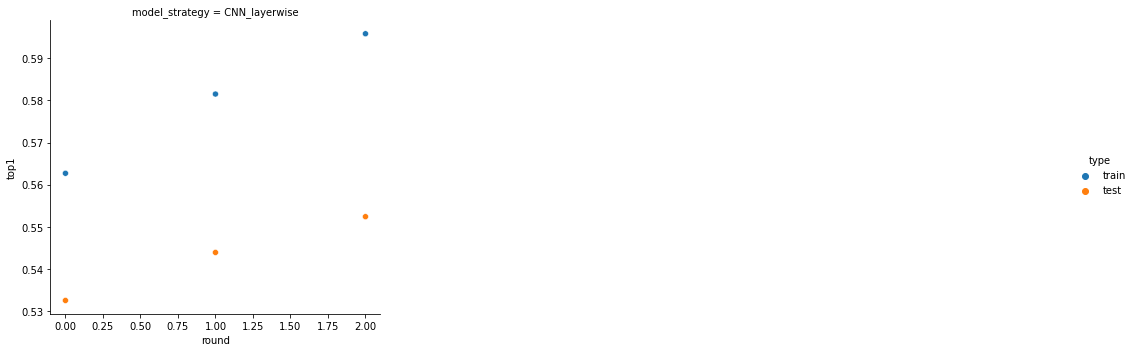

In [179]:
sns.relplot(
    data=all_df[(all_df['epoch'] == all_df['epoch'].max()) & (all_df['layer'] == all_df['layer'].max())],
    x='round',
    y='top1',
    hue='type',
    col='model_strategy',
    col_wrap=3
)

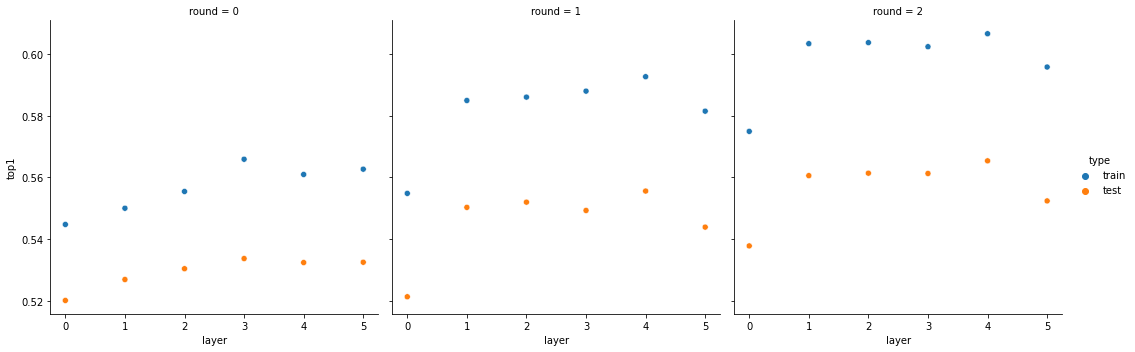

In [180]:
sns.relplot(
    data=all_df[(all_df['epoch'] == all_df['epoch'].max())],
    x='layer',
    y='top1',
    hue='type',
    col='round',
    col_wrap=3
)

# Section

In [189]:
mlp_bp_model, mlp_bp_results_df = full_backprop_training(models.LayerwiseConfigurableMLP())

cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
finished


In [219]:
mlp_bp_model = models.LayerwiseConfigurableMLP()
for i in range(0, config.get_global_configuration()['rounds']):
    mlp_bp_model, mlp_bp_results_df = full_backprop_training(mlp_bp_model, rnd=i)

cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
finished
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
finished
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verif

In [218]:
cnn_bp_model = models.LayerwiseConfigurableCNN()
for i in range(0, config.get_global_configuration()['rounds']):
    cnn_bp_model, cnn_bp_results_df = full_backprop_training(cnn_bp_model, rnd=i)

cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
finished
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
finished
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verif

In [190]:
cnn_model = models.LayerwiseConfigurableCNN()
for i in range(0, config.get_global_configuration()['rounds']):
    print(f'round {i}')
    cnn_model, cnn_results_df = greedy_layerwise_training(cnn_model, i)

cuda:0
round 0
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
Training process has finished.
finished
round 1
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
Training process has finished.
finished
round 2
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cu

In [191]:
mlp_model = models.LayerwiseConfigurableMLP()
for i in range(config.get_global_configuration()['rounds']):
    print(f'round {i}')
    mlp_model, mlp_results_df = greedy_layerwise_training(mlp_model, i)

cuda:0
round 0
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Training process has finished.
finished
round 1
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

Training process has finished.
finished
round 2
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

Training process has finished.
finished
round 3
NEW!
cuda:0
cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

Training process has finished.
finished


In [192]:
cnn_bp_model, cnn_bp_results_df = full_backprop_training(models.LayerwiseConfigurableCNN())

cuda:0
cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f64ac08eb90>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    s

cuda:0
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Files already downloaded and verified
Files already downloaded and verified
finished


Questions

1) Understanding the curvature of the loss function - how to compute the Hessian
2) Should I freeze the output layer?
3) What does it mean to set W_L using the neural collapse property?
4) Skip connections - does that mean that each layer needs to have the same output dimension as the final output dimension? Do we just sum them up at the end
5) Training Resources
6) Weight Decay? Batch Normalization?
7) Width of Hidden Layers in MLP

8) Depth of MLP
9) Number of Channels in CNN
10) Kernel Size in CNN

Lecture

1) Understanding, as a mathematician, the critical points of L
2) Goal


For deep (l >= 3) nonlinear networks, bad local (non-global) minimima exist - that are difficult to escape
Morse Function. A function L: R^d -> R is MOrse if at every critical point p in R^d the Hessian Hess(L) (p) is nonsingular (i.e. has no 0 eigenvalues)

1) If L is Morse, can understand the topology of u by computing all the critical points of L and geometry near them
2) Almost every c^2 function is Morse (Morse functions are open, dense in C^2)

Morse-Bott function
Allow for non-isolated critical points
L: R^d -> R is Morse Bott f critical locus is a closed submanifold and Hess(L) is nonsingular in normal directions to that submanifold

Geometry changes significantly across regimes
- width > n
- width > poly(n)
- width > sqrt(n)

As soon as there exists 